In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [2]:
# Parameters
CELL_TYPE = "PBMC"
CONTROL_NAME = "DMSO_0.100_%_DMSO_0.025_%"
TREATMENT_NAME = "Thapsigargin_1.000_uM_DMSO_0.025_%"
MODEL_NAME = "DMSO_0.025_vs_Thapsigargin_1"
SHUFFLE = False

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [5]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_%_DMSO_0.025_%' 'Thapsigargin_1.000_uM_DMSO_0.025_%']
The dimensions of the data are: (363586, 1270)


Number of total missing values across all columns: 0
Data Subset Is Off


In [6]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['J06' 'K07']
Wells to use for training, validation, and testing ['B06' 'C06' 'B07' 'C07' 'D06' 'D07' 'I06' 'I07' 'K06' 'J07']


In [7]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [8]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [9]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=mlp_params.TRAIN_PROPORTION_SPLIT,
    val_proportion=mlp_params.VALIDATION_PROPORTION_SPLIT,
    test_proportion=mlp_params.TEST_PROPORTION_SPLIT,
    # train_proportion=0.8,
    # val_proportion=0.1,
    # test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [10]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [11]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1245
Number of out features:  2
Binary_Classification


In [12]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [13]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam


Epoch 0: Validation loss decreased (inf --> 0.507846).  Saving model ...
	 Train_Loss: 0.5872 Train_Acc: 68.516 Val_Loss: 0.5078  BEST VAL Loss: 0.5078  Val_Acc: 74.532



Epoch 1: Validation loss decreased (0.507846 --> 0.484653).  Saving model ...
	 Train_Loss: 0.5455 Train_Acc: 74.282 Val_Loss: 0.4847  BEST VAL Loss: 0.4847  Val_Acc: 77.232



Epoch 2: Validation loss decreased (0.484653 --> 0.471349).  Saving model ...
	 Train_Loss: 0.5216 Train_Acc: 76.268 Val_Loss: 0.4713  BEST VAL Loss: 0.4713  Val_Acc: 78.248



Epoch 3: Validation loss decreased (0.471349 --> 0.460127).  Saving model ...
	 Train_Loss: 0.5053 Train_Acc: 77.358 Val_Loss: 0.4601  BEST VAL Loss: 0.4601  Val_Acc: 79.506



Epoch 4: Validation loss decreased (0.460127 --> 0.449687).  Saving model ...
	 Train_Loss: 0.4923 Train_Acc: 78.275 Val_Loss: 0.4497  BEST VAL Loss: 0.4497  Val_Acc: 80.646



Epoch 5: Validation loss decreased (0.449687 --> 0.441168).  Saving model ...
	 Train_Loss: 0.4811 Train_Acc: 79.114 Val_Loss: 0.4412  BEST VAL Loss: 0.4412  Val_Acc: 81.298



Epoch 6: Validation loss decreased (0.441168 --> 0.434127).  Saving model ...
	 Train_Loss: 0.4719 Train_Acc: 79.716 Val_Loss: 0.4341  BEST VAL Loss: 0.4341  Val_Acc: 81.688



Epoch 7: Validation loss decreased (0.434127 --> 0.427243).  Saving model ...
	 Train_Loss: 0.4637 Train_Acc: 80.124 Val_Loss: 0.4272  BEST VAL Loss: 0.4272  Val_Acc: 82.542



Epoch 8: Validation loss decreased (0.427243 --> 0.420976).  Saving model ...
	 Train_Loss: 0.4564 Train_Acc: 80.745 Val_Loss: 0.4210  BEST VAL Loss: 0.4210  Val_Acc: 82.919



Epoch 9: Validation loss decreased (0.420976 --> 0.415152).  Saving model ...
	 Train_Loss: 0.4499 Train_Acc: 81.065 Val_Loss: 0.4152  BEST VAL Loss: 0.4152  Val_Acc: 83.181



Epoch 10: Validation loss decreased (0.415152 --> 0.410439).  Saving model ...
	 Train_Loss: 0.4441 Train_Acc: 81.263 Val_Loss: 0.4104  BEST VAL Loss: 0.4104  Val_Acc: 83.346



Epoch 11: Validation loss decreased (0.410439 --> 0.405582).  Saving model ...
	 Train_Loss: 0.4389 Train_Acc: 81.522 Val_Loss: 0.4056  BEST VAL Loss: 0.4056  Val_Acc: 83.851



Epoch 12: Validation loss decreased (0.405582 --> 0.401130).  Saving model ...
	 Train_Loss: 0.4342 Train_Acc: 81.736 Val_Loss: 0.4011  BEST VAL Loss: 0.4011  Val_Acc: 84.160



Epoch 13: Validation loss decreased (0.401130 --> 0.397087).  Saving model ...
	 Train_Loss: 0.4300 Train_Acc: 81.897 Val_Loss: 0.3971  BEST VAL Loss: 0.3971  Val_Acc: 84.063



Epoch 14: Validation loss decreased (0.397087 --> 0.393784).  Saving model ...
	 Train_Loss: 0.4262 Train_Acc: 82.111 Val_Loss: 0.3938  BEST VAL Loss: 0.3938  Val_Acc: 84.392



Epoch 15: Validation loss decreased (0.393784 --> 0.390541).  Saving model ...
	 Train_Loss: 0.4227 Train_Acc: 82.174 Val_Loss: 0.3905  BEST VAL Loss: 0.3905  Val_Acc: 84.466



Epoch 16: Validation loss decreased (0.390541 --> 0.387643).  Saving model ...
	 Train_Loss: 0.4195 Train_Acc: 82.337 Val_Loss: 0.3876  BEST VAL Loss: 0.3876  Val_Acc: 84.422



Epoch 17: Validation loss decreased (0.387643 --> 0.384974).  Saving model ...
	 Train_Loss: 0.4166 Train_Acc: 82.425 Val_Loss: 0.3850  BEST VAL Loss: 0.3850  Val_Acc: 84.436



Epoch 18: Validation loss decreased (0.384974 --> 0.382694).  Saving model ...
	 Train_Loss: 0.4139 Train_Acc: 82.423 Val_Loss: 0.3827  BEST VAL Loss: 0.3827  Val_Acc: 84.432



Epoch 19: Validation loss decreased (0.382694 --> 0.380531).  Saving model ...
	 Train_Loss: 0.4115 Train_Acc: 82.504 Val_Loss: 0.3805  BEST VAL Loss: 0.3805  Val_Acc: 84.436



Epoch 20: Validation loss decreased (0.380531 --> 0.378572).  Saving model ...
	 Train_Loss: 0.4092 Train_Acc: 82.580 Val_Loss: 0.3786  BEST VAL Loss: 0.3786  Val_Acc: 84.389



Epoch 21: Validation loss decreased (0.378572 --> 0.376728).  Saving model ...
	 Train_Loss: 0.4070 Train_Acc: 82.621 Val_Loss: 0.3767  BEST VAL Loss: 0.3767  Val_Acc: 84.614



Epoch 22: Validation loss decreased (0.376728 --> 0.375134).  Saving model ...
	 Train_Loss: 0.4050 Train_Acc: 82.747 Val_Loss: 0.3751  BEST VAL Loss: 0.3751  Val_Acc: 84.543



Epoch 23: Validation loss decreased (0.375134 --> 0.373485).  Saving model ...
	 Train_Loss: 0.4031 Train_Acc: 82.783 Val_Loss: 0.3735  BEST VAL Loss: 0.3735  Val_Acc: 84.597



Epoch 24: Validation loss decreased (0.373485 --> 0.371951).  Saving model ...
	 Train_Loss: 0.4013 Train_Acc: 82.859 Val_Loss: 0.3720  BEST VAL Loss: 0.3720  Val_Acc: 84.772



Epoch 25: Validation loss decreased (0.371951 --> 0.370464).  Saving model ...
	 Train_Loss: 0.3996 Train_Acc: 82.972 Val_Loss: 0.3705  BEST VAL Loss: 0.3705  Val_Acc: 84.870



Epoch 26: Validation loss decreased (0.370464 --> 0.369111).  Saving model ...
	 Train_Loss: 0.3980 Train_Acc: 82.991 Val_Loss: 0.3691  BEST VAL Loss: 0.3691  Val_Acc: 84.981



Epoch 27: Validation loss decreased (0.369111 --> 0.367717).  Saving model ...
	 Train_Loss: 0.3964 Train_Acc: 83.077 Val_Loss: 0.3677  BEST VAL Loss: 0.3677  Val_Acc: 84.954



Epoch 28: Validation loss decreased (0.367717 --> 0.366692).  Saving model ...
	 Train_Loss: 0.3949 Train_Acc: 83.100 Val_Loss: 0.3667  BEST VAL Loss: 0.3667  Val_Acc: 84.718



Epoch 29: Validation loss decreased (0.366692 --> 0.365640).  Saving model ...
	 Train_Loss: 0.3935 Train_Acc: 83.178 Val_Loss: 0.3656  BEST VAL Loss: 0.3656  Val_Acc: 84.702



Epoch 30: Validation loss decreased (0.365640 --> 0.364596).  Saving model ...
	 Train_Loss: 0.3922 Train_Acc: 83.152 Val_Loss: 0.3646  BEST VAL Loss: 0.3646  Val_Acc: 84.796



Epoch 31: Validation loss decreased (0.364596 --> 0.363608).  Saving model ...
	 Train_Loss: 0.3910 Train_Acc: 83.192 Val_Loss: 0.3636  BEST VAL Loss: 0.3636  Val_Acc: 84.917



Epoch 32: Validation loss decreased (0.363608 --> 0.362815).  Saving model ...
	 Train_Loss: 0.3898 Train_Acc: 83.211 Val_Loss: 0.3628  BEST VAL Loss: 0.3628  Val_Acc: 84.850



Epoch 33: Validation loss decreased (0.362815 --> 0.361956).  Saving model ...
	 Train_Loss: 0.3886 Train_Acc: 83.312 Val_Loss: 0.3620  BEST VAL Loss: 0.3620  Val_Acc: 85.018



Epoch 34: Validation loss decreased (0.361956 --> 0.361109).  Saving model ...
	 Train_Loss: 0.3875 Train_Acc: 83.290 Val_Loss: 0.3611  BEST VAL Loss: 0.3611  Val_Acc: 84.964



Epoch 35: Validation loss decreased (0.361109 --> 0.360271).  Saving model ...
	 Train_Loss: 0.3865 Train_Acc: 83.270 Val_Loss: 0.3603  BEST VAL Loss: 0.3603  Val_Acc: 84.799



Epoch 36: Validation loss decreased (0.360271 --> 0.359371).  Saving model ...
	 Train_Loss: 0.3855 Train_Acc: 83.393 Val_Loss: 0.3594  BEST VAL Loss: 0.3594  Val_Acc: 85.034



Epoch 37: Validation loss decreased (0.359371 --> 0.358606).  Saving model ...
	 Train_Loss: 0.3845 Train_Acc: 83.407 Val_Loss: 0.3586  BEST VAL Loss: 0.3586  Val_Acc: 85.357



Epoch 38: Validation loss decreased (0.358606 --> 0.357936).  Saving model ...
	 Train_Loss: 0.3836 Train_Acc: 83.347 Val_Loss: 0.3579  BEST VAL Loss: 0.3579  Val_Acc: 85.199



Epoch 39: Validation loss decreased (0.357936 --> 0.357279).  Saving model ...
	 Train_Loss: 0.3827 Train_Acc: 83.457 Val_Loss: 0.3573  BEST VAL Loss: 0.3573  Val_Acc: 84.923



Epoch 40: Validation loss decreased (0.357279 --> 0.356564).  Saving model ...
	 Train_Loss: 0.3818 Train_Acc: 83.442 Val_Loss: 0.3566  BEST VAL Loss: 0.3566  Val_Acc: 85.327



Epoch 41: Validation loss decreased (0.356564 --> 0.355963).  Saving model ...
	 Train_Loss: 0.3810 Train_Acc: 83.518 Val_Loss: 0.3560  BEST VAL Loss: 0.3560  Val_Acc: 85.196



Epoch 42: Validation loss decreased (0.355963 --> 0.355306).  Saving model ...
	 Train_Loss: 0.3802 Train_Acc: 83.567 Val_Loss: 0.3553  BEST VAL Loss: 0.3553  Val_Acc: 85.391



Epoch 43: Validation loss decreased (0.355306 --> 0.354655).  Saving model ...
	 Train_Loss: 0.3794 Train_Acc: 83.537 Val_Loss: 0.3547  BEST VAL Loss: 0.3547  Val_Acc: 85.344



Epoch 44: Validation loss decreased (0.354655 --> 0.354073).  Saving model ...
	 Train_Loss: 0.3786 Train_Acc: 83.615 Val_Loss: 0.3541  BEST VAL Loss: 0.3541  Val_Acc: 85.364



Epoch 45: Validation loss decreased (0.354073 --> 0.353532).  Saving model ...
	 Train_Loss: 0.3778 Train_Acc: 83.687 Val_Loss: 0.3535  BEST VAL Loss: 0.3535  Val_Acc: 85.307



Epoch 46: Validation loss decreased (0.353532 --> 0.352998).  Saving model ...
	 Train_Loss: 0.3771 Train_Acc: 83.612 Val_Loss: 0.3530  BEST VAL Loss: 0.3530  Val_Acc: 85.361



Epoch 47: Validation loss decreased (0.352998 --> 0.352494).  Saving model ...
	 Train_Loss: 0.3764 Train_Acc: 83.619 Val_Loss: 0.3525  BEST VAL Loss: 0.3525  Val_Acc: 85.317



Epoch 48: Validation loss decreased (0.352494 --> 0.351967).  Saving model ...
	 Train_Loss: 0.3757 Train_Acc: 83.684 Val_Loss: 0.3520  BEST VAL Loss: 0.3520  Val_Acc: 85.364



Epoch 49: Validation loss decreased (0.351967 --> 0.351448).  Saving model ...
	 Train_Loss: 0.3751 Train_Acc: 83.776 Val_Loss: 0.3514  BEST VAL Loss: 0.3514  Val_Acc: 85.626



Epoch 50: Validation loss decreased (0.351448 --> 0.350999).  Saving model ...
	 Train_Loss: 0.3744 Train_Acc: 83.816 Val_Loss: 0.3510  BEST VAL Loss: 0.3510  Val_Acc: 85.001



Epoch 51: Validation loss decreased (0.350999 --> 0.350485).  Saving model ...
	 Train_Loss: 0.3738 Train_Acc: 83.690 Val_Loss: 0.3505  BEST VAL Loss: 0.3505  Val_Acc: 85.381



Epoch 52: Validation loss decreased (0.350485 --> 0.350030).  Saving model ...
	 Train_Loss: 0.3732 Train_Acc: 83.710 Val_Loss: 0.3500  BEST VAL Loss: 0.3500  Val_Acc: 85.317



Epoch 53: Validation loss decreased (0.350030 --> 0.349591).  Saving model ...
	 Train_Loss: 0.3726 Train_Acc: 83.812 Val_Loss: 0.3496  BEST VAL Loss: 0.3496  Val_Acc: 85.361



Epoch 54: Validation loss decreased (0.349591 --> 0.349167).  Saving model ...
	 Train_Loss: 0.3720 Train_Acc: 83.813 Val_Loss: 0.3492  BEST VAL Loss: 0.3492  Val_Acc: 85.421



Epoch 55: Validation loss decreased (0.349167 --> 0.348681).  Saving model ...
	 Train_Loss: 0.3715 Train_Acc: 83.863 Val_Loss: 0.3487  BEST VAL Loss: 0.3487  Val_Acc: 85.650



Epoch 56: Validation loss decreased (0.348681 --> 0.348311).  Saving model ...
	 Train_Loss: 0.3709 Train_Acc: 83.918 Val_Loss: 0.3483  BEST VAL Loss: 0.3483  Val_Acc: 85.324



Epoch 57: Validation loss decreased (0.348311 --> 0.347949).  Saving model ...
	 Train_Loss: 0.3704 Train_Acc: 83.856 Val_Loss: 0.3479  BEST VAL Loss: 0.3479  Val_Acc: 85.418



Epoch 58: Validation loss decreased (0.347949 --> 0.347542).  Saving model ...
	 Train_Loss: 0.3699 Train_Acc: 83.865 Val_Loss: 0.3475  BEST VAL Loss: 0.3475  Val_Acc: 85.589



Epoch 59: Validation loss decreased (0.347542 --> 0.347155).  Saving model ...
	 Train_Loss: 0.3694 Train_Acc: 83.893 Val_Loss: 0.3472  BEST VAL Loss: 0.3472  Val_Acc: 85.428



Epoch 60: Validation loss decreased (0.347155 --> 0.346809).  Saving model ...
	 Train_Loss: 0.3689 Train_Acc: 83.801 Val_Loss: 0.3468  BEST VAL Loss: 0.3468  Val_Acc: 85.475



Epoch 61: Validation loss decreased (0.346809 --> 0.346516).  Saving model ...
	 Train_Loss: 0.3684 Train_Acc: 83.909 Val_Loss: 0.3465  BEST VAL Loss: 0.3465  Val_Acc: 85.330



Epoch 62: Validation loss decreased (0.346516 --> 0.346157).  Saving model ...
	 Train_Loss: 0.3680 Train_Acc: 83.905 Val_Loss: 0.3462  BEST VAL Loss: 0.3462  Val_Acc: 85.603



Epoch 63: Validation loss decreased (0.346157 --> 0.345808).  Saving model ...
	 Train_Loss: 0.3675 Train_Acc: 83.961 Val_Loss: 0.3458  BEST VAL Loss: 0.3458  Val_Acc: 85.546



Epoch 64: Validation loss decreased (0.345808 --> 0.345489).  Saving model ...
	 Train_Loss: 0.3670 Train_Acc: 83.962 Val_Loss: 0.3455  BEST VAL Loss: 0.3455  Val_Acc: 85.478



Epoch 65: Validation loss decreased (0.345489 --> 0.345177).  Saving model ...
	 Train_Loss: 0.3666 Train_Acc: 83.947 Val_Loss: 0.3452  BEST VAL Loss: 0.3452  Val_Acc: 85.445



Epoch 66: Validation loss decreased (0.345177 --> 0.344890).  Saving model ...
	 Train_Loss: 0.3662 Train_Acc: 83.981 Val_Loss: 0.3449  BEST VAL Loss: 0.3449  Val_Acc: 85.640



Epoch 67: Validation loss decreased (0.344890 --> 0.344573).  Saving model ...
	 Train_Loss: 0.3657 Train_Acc: 84.048 Val_Loss: 0.3446  BEST VAL Loss: 0.3446  Val_Acc: 85.576



Epoch 68: Validation loss decreased (0.344573 --> 0.344319).  Saving model ...
	 Train_Loss: 0.3653 Train_Acc: 84.042 Val_Loss: 0.3443  BEST VAL Loss: 0.3443  Val_Acc: 85.337



Epoch 69: Validation loss decreased (0.344319 --> 0.344039).  Saving model ...
	 Train_Loss: 0.3649 Train_Acc: 84.067 Val_Loss: 0.3440  BEST VAL Loss: 0.3440  Val_Acc: 85.657



Epoch 70: Validation loss decreased (0.344039 --> 0.343729).  Saving model ...
	 Train_Loss: 0.3645 Train_Acc: 84.088 Val_Loss: 0.3437  BEST VAL Loss: 0.3437  Val_Acc: 85.657



Epoch 71: Validation loss decreased (0.343729 --> 0.343438).  Saving model ...
	 Train_Loss: 0.3641 Train_Acc: 84.095 Val_Loss: 0.3434  BEST VAL Loss: 0.3434  Val_Acc: 85.721



Epoch 72: Validation loss decreased (0.343438 --> 0.343193).  Saving model ...
	 Train_Loss: 0.3637 Train_Acc: 84.044 Val_Loss: 0.3432  BEST VAL Loss: 0.3432  Val_Acc: 85.401



Epoch 73: Validation loss decreased (0.343193 --> 0.342913).  Saving model ...
	 Train_Loss: 0.3633 Train_Acc: 84.146 Val_Loss: 0.3429  BEST VAL Loss: 0.3429  Val_Acc: 85.626



Epoch 74: Validation loss decreased (0.342913 --> 0.342644).  Saving model ...
	 Train_Loss: 0.3630 Train_Acc: 84.154 Val_Loss: 0.3426  BEST VAL Loss: 0.3426  Val_Acc: 85.680



Epoch 75: Validation loss decreased (0.342644 --> 0.342426).  Saving model ...
	 Train_Loss: 0.3626 Train_Acc: 84.207 Val_Loss: 0.3424  BEST VAL Loss: 0.3424  Val_Acc: 85.593



Epoch 76: Validation loss decreased (0.342426 --> 0.342162).  Saving model ...
	 Train_Loss: 0.3622 Train_Acc: 84.196 Val_Loss: 0.3422  BEST VAL Loss: 0.3422  Val_Acc: 85.643



Epoch 77: Validation loss decreased (0.342162 --> 0.341887).  Saving model ...
	 Train_Loss: 0.3619 Train_Acc: 84.220 Val_Loss: 0.3419  BEST VAL Loss: 0.3419  Val_Acc: 85.667



Epoch 78: Validation loss decreased (0.341887 --> 0.341675).  Saving model ...
	 Train_Loss: 0.3615 Train_Acc: 84.151 Val_Loss: 0.3417  BEST VAL Loss: 0.3417  Val_Acc: 85.623



Epoch 79: Validation loss decreased (0.341675 --> 0.341423).  Saving model ...
	 Train_Loss: 0.3612 Train_Acc: 84.176 Val_Loss: 0.3414  BEST VAL Loss: 0.3414  Val_Acc: 85.633



Epoch 80: Validation loss decreased (0.341423 --> 0.341218).  Saving model ...
	 Train_Loss: 0.3609 Train_Acc: 84.229 Val_Loss: 0.3412  BEST VAL Loss: 0.3412  Val_Acc: 85.593



Epoch 81: Validation loss decreased (0.341218 --> 0.340966).  Saving model ...
	 Train_Loss: 0.3605 Train_Acc: 84.244 Val_Loss: 0.3410  BEST VAL Loss: 0.3410  Val_Acc: 85.680



Epoch 82: Validation loss decreased (0.340966 --> 0.340721).  Saving model ...
	 Train_Loss: 0.3602 Train_Acc: 84.176 Val_Loss: 0.3407  BEST VAL Loss: 0.3407  Val_Acc: 85.872



Epoch 83: Validation loss decreased (0.340721 --> 0.340502).  Saving model ...
	 Train_Loss: 0.3599 Train_Acc: 84.273 Val_Loss: 0.3405  BEST VAL Loss: 0.3405  Val_Acc: 85.573



Epoch 84: Validation loss decreased (0.340502 --> 0.340309).  Saving model ...
	 Train_Loss: 0.3596 Train_Acc: 84.174 Val_Loss: 0.3403  BEST VAL Loss: 0.3403  Val_Acc: 85.808



Epoch 85: Validation loss decreased (0.340309 --> 0.340136).  Saving model ...
	 Train_Loss: 0.3593 Train_Acc: 84.291 Val_Loss: 0.3401  BEST VAL Loss: 0.3401  Val_Acc: 85.751



Epoch 86: Validation loss decreased (0.340136 --> 0.339921).  Saving model ...
	 Train_Loss: 0.3590 Train_Acc: 84.283 Val_Loss: 0.3399  BEST VAL Loss: 0.3399  Val_Acc: 85.690



Epoch 87: Validation loss decreased (0.339921 --> 0.339715).  Saving model ...
	 Train_Loss: 0.3587 Train_Acc: 84.211 Val_Loss: 0.3397  BEST VAL Loss: 0.3397  Val_Acc: 85.667



Epoch 88: Validation loss decreased (0.339715 --> 0.339516).  Saving model ...
	 Train_Loss: 0.3584 Train_Acc: 84.254 Val_Loss: 0.3395  BEST VAL Loss: 0.3395  Val_Acc: 85.673



Epoch 89: Validation loss decreased (0.339516 --> 0.339347).  Saving model ...
	 Train_Loss: 0.3581 Train_Acc: 84.272 Val_Loss: 0.3393  BEST VAL Loss: 0.3393  Val_Acc: 85.778



Epoch 90: Validation loss decreased (0.339347 --> 0.339104).  Saving model ...
	 Train_Loss: 0.3578 Train_Acc: 84.332 Val_Loss: 0.3391  BEST VAL Loss: 0.3391  Val_Acc: 85.680



Epoch 91: Validation loss decreased (0.339104 --> 0.338909).  Saving model ...
	 Train_Loss: 0.3575 Train_Acc: 84.267 Val_Loss: 0.3389  BEST VAL Loss: 0.3389  Val_Acc: 85.643



Epoch 92: Validation loss decreased (0.338909 --> 0.338751).  Saving model ...
	 Train_Loss: 0.3572 Train_Acc: 84.379 Val_Loss: 0.3388  BEST VAL Loss: 0.3388  Val_Acc: 85.670



Epoch 93: Validation loss decreased (0.338751 --> 0.338614).  Saving model ...
	 Train_Loss: 0.3570 Train_Acc: 84.310 Val_Loss: 0.3386  BEST VAL Loss: 0.3386  Val_Acc: 85.509



Epoch 94: Validation loss decreased (0.338614 --> 0.338459).  Saving model ...
	 Train_Loss: 0.3567 Train_Acc: 84.305 Val_Loss: 0.3385  BEST VAL Loss: 0.3385  Val_Acc: 85.593



Epoch 95: Validation loss decreased (0.338459 --> 0.338308).  Saving model ...
	 Train_Loss: 0.3565 Train_Acc: 84.373 Val_Loss: 0.3383  BEST VAL Loss: 0.3383  Val_Acc: 85.663



Epoch 96: Validation loss decreased (0.338308 --> 0.338209).  Saving model ...
	 Train_Loss: 0.3562 Train_Acc: 84.415 Val_Loss: 0.3382  BEST VAL Loss: 0.3382  Val_Acc: 85.721



Epoch 97: Validation loss decreased (0.338209 --> 0.338057).  Saving model ...
	 Train_Loss: 0.3559 Train_Acc: 84.377 Val_Loss: 0.3381  BEST VAL Loss: 0.3381  Val_Acc: 85.653



Epoch 98: Validation loss decreased (0.338057 --> 0.337894).  Saving model ...
	 Train_Loss: 0.3557 Train_Acc: 84.298 Val_Loss: 0.3379  BEST VAL Loss: 0.3379  Val_Acc: 85.717



Epoch 99: Validation loss decreased (0.337894 --> 0.337747).  Saving model ...
	 Train_Loss: 0.3554 Train_Acc: 84.394 Val_Loss: 0.3377  BEST VAL Loss: 0.3377  Val_Acc: 85.653



In [14]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "treatments_tested",
        "model",
        "group",
        "shuffled_data",
        "PR_Threshold",
        "Precision",
        "Recall",
    ]
)
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall


/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1001: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1002: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


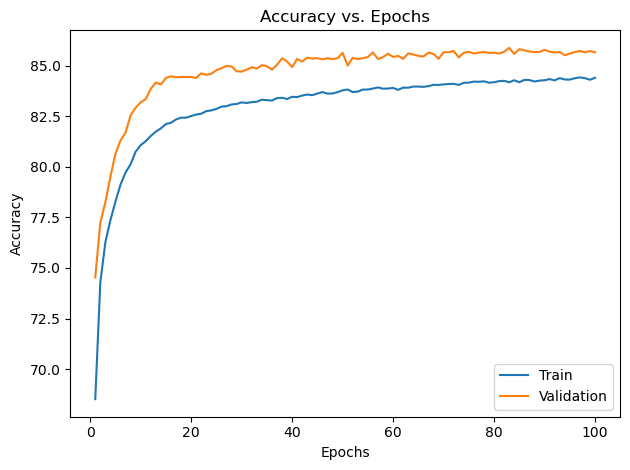

In [15]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1001: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1002: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


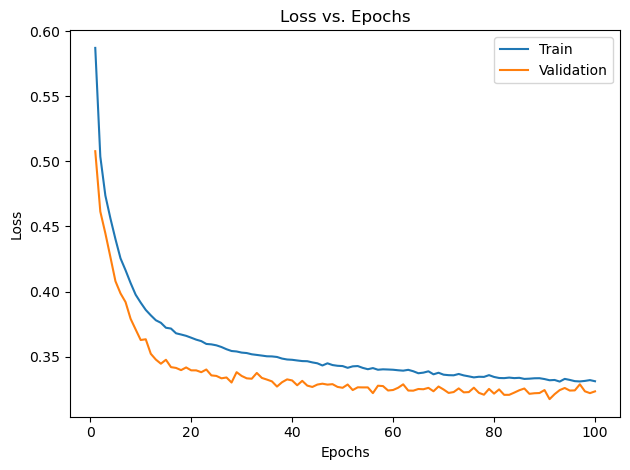

In [16]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

In [17]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [18]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90    149884
           1       0.85      0.80      0.82     87993

    accuracy                           0.87    237877
   macro avg       0.87      0.86      0.86    237877
weighted avg       0.87      0.87      0.87    237877



In [19]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [20]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [21]:
mlp_params.SHUFFLE

False

In [22]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_validation",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     18736
           1       0.83      0.78      0.80     10999

    accuracy                           0.86     29735
   macro avg       0.85      0.84      0.84     29735
weighted avg       0.86      0.86      0.86     29735



In [23]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [24]:
mlp_params.MODEL_NAME

'DMSO_0.025_vs_Thapsigargin_1'

In [25]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.87      0.91      0.89     18736
           1       0.83      0.77      0.80     10999

    accuracy                           0.86     29735
   macro avg       0.85      0.84      0.84     29735
weighted avg       0.85      0.86      0.85     29735



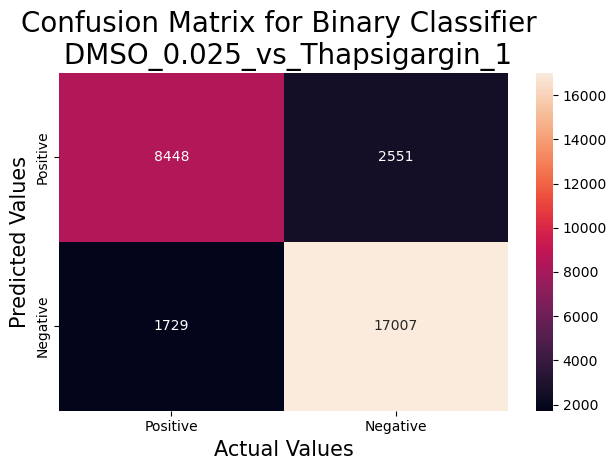

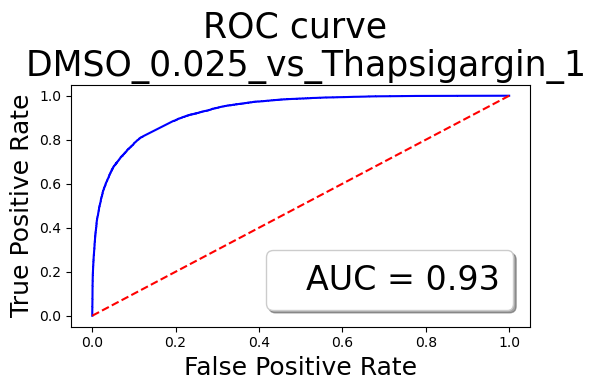

In [26]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [27]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_test",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     18736
           1       0.83      0.77      0.80     10999

    accuracy                           0.86     29735
   macro avg       0.85      0.84      0.84     29735
weighted avg       0.85      0.86      0.85     29735



In [28]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

## Test the hold out wells

In [29]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [30]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.74      0.81      0.78     27774
           1       0.85      0.80      0.83     38465

    accuracy                           0.80     66239
   macro avg       0.80      0.81      0.80     66239
weighted avg       0.81      0.80      0.80     66239



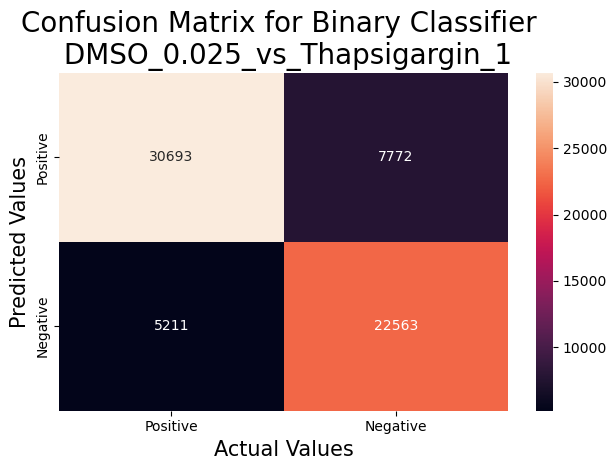

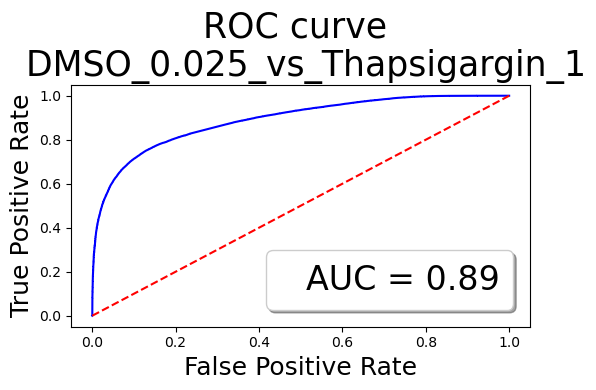

In [31]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [32]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    df_values_Y,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_hold_out",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.74      0.81      0.78     27774
           1       0.85      0.80      0.83     38465

    accuracy                           0.80     66239
   macro avg       0.80      0.81      0.80     66239
weighted avg       0.81      0.80      0.80     66239



In [33]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [34]:
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall
0,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369910,1.000000
1,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369939,1.000000
2,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369941,1.000000
3,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369942,1.000000
4,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369944,1.000000
...,...,...,...,...,...,...,...
62802,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999983,0.714286,0.000130
62803,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999986,0.666667,0.000104
62804,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999997,0.600000,0.000078
62805,DMSO_0.100_%_DMSO_0.025_% vs. Thapsigargin_1.0...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,1.0,0.500000,0.000052


In [35]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)